Sử dụng bộ phân loại Softmax để phân loại MNIST

In [1]:
!pip install torch torchvision torchaudio

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

Tạo hàm vẽ các tham số cho Softmax

In [3]:
def PlotParameters(model):
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2,5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            ax.set_xlabel("Class: {0}".format(i))
            ax.imshow(W[i, :].view(28,28), vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
            
    plt.show()
    

In [4]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28,28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the valodation dataset:\n", validation_dataset)

Print the valodation dataset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Firt Image and Label:  None


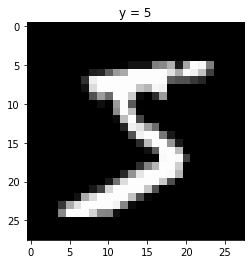

In [7]:
print("Firt Image and Label: ", show_data(train_dataset[0]))

Mỗi phần tử trong tensor hình chữ nhật tương ứng với một số đại diện cho cường độ pixel, như được minh họa bằng hình ảnh sau:

In [8]:
print("The label: ", train_dataset[2][1])

The label:  4


In [9]:
print("The label: ", validation_dataset[2][1])

The label:  4


Build a Softmax Classifer

In [10]:
# Kế thừa lớp nn.Module là cơ sở cho tất cả mạng nơ-ron
class SoftMax(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
     
    #predict
    def forward(self, x):
        z = self.linear(x)
        
        return z

In [11]:
#set input_dim and output_dim
input_dim = 28*28
ouput_dim = 10

## Define the Softmax Classifier, Criterion Function, Optimizer, and Train the Model

In [12]:
model = SoftMax(input_dim, ouput_dim)
print('Print the model:\n', model)


Print the model:
 SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [13]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [14]:
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


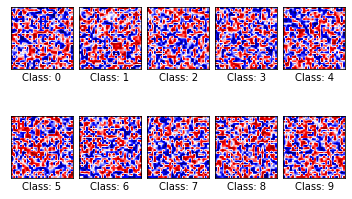

In [15]:
PlotParameters(model)

In [16]:
X = train_dataset[0][0]
print(X.shape)
X = X.view(-1, 28*28)
print(X.shape)
model(X)

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([[-0.0135,  0.4018, -0.2250, -0.1037,  0.0238, -0.0160, -0.1641,  0.1203,
          0.0877,  0.2843]], grad_fn=<AddmmBackward0>)

In [17]:
learning_rate = 0.1
#Trình tối ưu hóa sẽ cập nhật các tham số mô hình bằng tốc độ học
#The optimizer will updates the model parameters using the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Tiêu chí sẽ đo lường sự mất mát giữa giá trị dự đoán và giá trị nhãn thực tế
# Đây là nơi xảy ra SoftMax, nó được tích hợp vào Tổn thất Entropy chéo tiêu chí
criterion = nn.CrossEntropyLoss()
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)


Chúng ta có X là hình ảnh đầu tiên và actual là lớp chữ số mà hình ảnh đó thuộc về.
model_output là đầu ra mà mô hình gắn cho lớp đó

Output:  tensor([[-0.0135,  0.4018, -0.2250, -0.1037,  0.0238, -0.0160, -0.1641,  0.1203,
          0.0877,  0.2843]], grad_fn=<AddmmBackward0>)
Actual:  tensor([5])


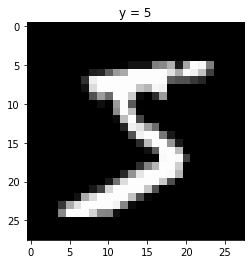

In [18]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

show_data(train_dataset[0])
print('Output: ',model_output)
print('Actual: ',actual)


In [19]:
criterion(model_output, actual)

tensor(2.3755, grad_fn=<NllLossBackward0>)

Đây không phải là xác suất, cần phải có Softmax để có được xác suất

In [20]:
softmax = nn.Softmax(dim=1)
probability = softmax(model_output)
print(probability)

tensor([[0.0932, 0.1412, 0.0754, 0.0852, 0.0967, 0.0930, 0.0802, 0.1065, 0.1031,
         0.1255]], grad_fn=<SoftmaxBackward0>)


Bây giờ đã có xác suất, chúng ta chỉ cần tính log âm của xác suất của lớp mà hình ảnh này thuộc về.
Hình ảnh thuộc về lớp mục tiêu nên chúng tôi tính toán log âm của xác suất tại chỉ mục mục tiêu

In [21]:
-1*torch.log(probability[0][actual])

tensor([2.3755], grad_fn=<MulBackward0>)

In [28]:
#số lần huấn luyện mô hình bằng dữ liệu train train_dataset
n_epochs = 10

#danh sach theo dõi mất mát và độ chính xác
loss_list = []
accuracy_list = []

N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        
        for x, y in train_loader:
            optimizer.zero_grad()
            # Đưa ra dự đoán hình ảnh tensor
            z = model(x.view(-1, 28*28))
            # tính toán tổn thất giữa đầu ra và lớp thực tế
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
        correct = 0
        for x_test, y_test in validation_loader:
            # Đưa ra dự đoán dựa trên tensor hình ảnh
            z = model(x_test.view(-1,28*28))
            #Tìm lớp có kết quả cao nhất
            _,yhat = torch.max(z.data, 1)
            #Kiểm tra xem dự đoán có khớp với lớp thực tế không, tăng dần nếu đúng
            correct += (yhat == y_test).sum().item()
        # Tính toán độ chính xác bằng cách chia chính xác cho kích thước của tập dữ liệu xác thực
        accuracy = correct / N_test
        # Theo dõi mất mát
        loss_list.append(loss.data)
        # Theo dõi độ chính xác
        accuracy_list.append(accuracy)
        
train_model(n_epochs)
            



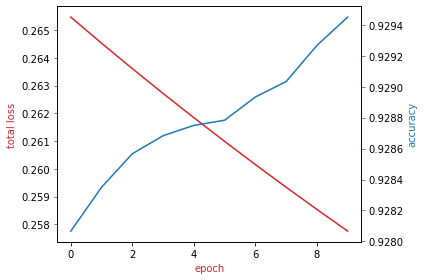

In [29]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

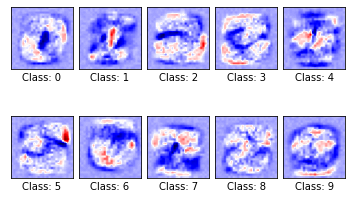

In [30]:
PlotParameters(model)

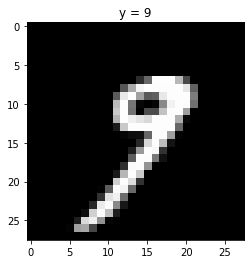

yhat: tensor([7])
probability of class  0.6228418350219727


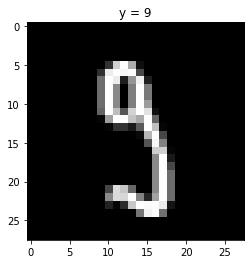

yhat: tensor([5])
probability of class  0.7433443069458008


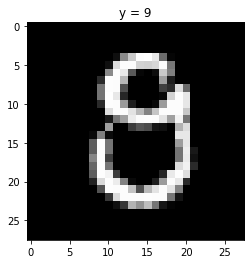

yhat: tensor([8])
probability of class  0.5012262463569641


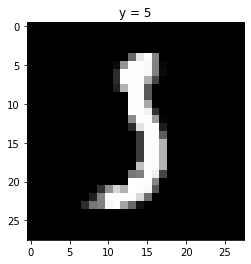

yhat: tensor([3])
probability of class  0.7207531332969666


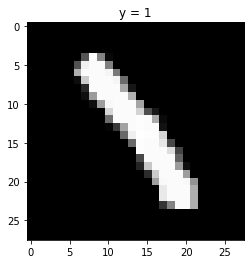

yhat: tensor([3])
probability of class  0.451454222202301


In [31]:
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break      

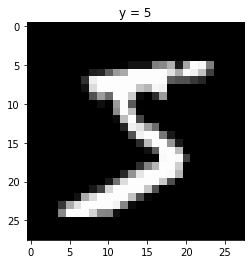

yhat: tensor([5])
probability of class  0.8549697995185852


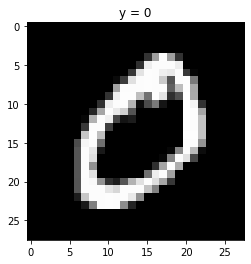

yhat: tensor([0])
probability of class  0.9999364614486694


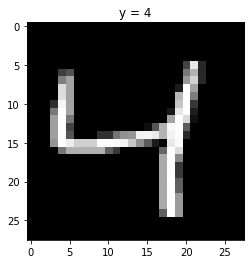

yhat: tensor([4])
probability of class  0.8059737682342529


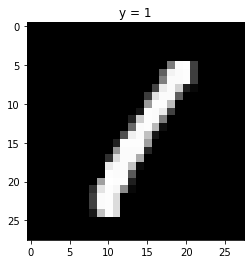

yhat: tensor([1])
probability of class  0.9682785868644714


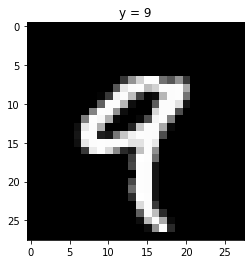

yhat: tensor([9])
probability of class  0.9458252191543579


In [32]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  